# Figure 3
___

In [1]:
import os

import scanpy as sc

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=120, facecolor='white', frameon=False)

import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import colors

# from Scrublet
def darken_cmap(cmap, scale_factor):
    cdat = np.zeros((cmap.N, 4))
    for ii in range(cdat.shape[0]):
        curcol = cmap(ii)
        cdat[ii,0] = curcol[0] * scale_factor
        cdat[ii,1] = curcol[1] * scale_factor
        cdat[ii,2] = curcol[2] * scale_factor
        cdat[ii,3] = 1
    cmap = cmap.from_list(cmap.N, cdat)
    return cmap
cmaps = darken_cmap(plt.cm.Reds, 0.9)

bone_reversed = plt.cm.get_cmap('bone_r')

In [24]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):     
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval), cmap(np.linspace(minval, maxval, n)))     
    return new_cmap  

cmap = plt.get_cmap('Blues_r', 50) 
# cmap = sns.color_palette('Blues_r')
new_cmap = truncate_colormap(cmap, 0.2, 0.75) 

In [8]:
def ColumnWiseCorrcoef(O, P):
    n = P.size
    DO = O - (np.sum(O, 0) / np.double(n))
    DP = P - (np.sum(P) / np.double(n))
    return np.dot(DP, DO) / np.sqrt(np.sum(DO ** 2, 0) * np.sum(DP ** 2))

Example of Actc1 and others
---

Characterise 2 classes: *intron retention (m)* and *exonic anti-sense overlap (x)* across regions.

In [7]:
parent = '/prj/Florian_Leuschner_spatial/analysis/Nanopore/' # change this path!
outname = 'scnast' # output generic name

filen = os.path.join(parent,  "Nanopore", "data", f"anatomical_regions_and_cell_props_{outname}.h5ad")
adata = sc.read_h5ad(filen)

raw = adata.raw.to_adata()

adata

AnnData object with n_obs × n_vars = 7616 × 12590
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_transcripts', 'pct_mt', 'library_id', 'anatomical_region', 'nanopore_only', 'C_scANVI'
    var: 'feature_types', 'genome', 'qry_id', 'ref_id', 'qry_gene_id', 'ref_gene_id', 'ref_gene_name', 'class_code', 'n_cells-A', 'n_cells-B', 'n_cells-C', 'n_cells-D'
    uns: 'C_scANVI_colors', 'anatomical_region_colors', 'hvg', 'library_id_colors', 'neighbors', 'spatial', 'umap'
    obsm: 'X_scANVI', 'X_umap', 'deconvolution', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [10]:
mapping_names = {'cardiac muscle cell': 'CMs', 'cardiac neuron': 'CNCs', 'endocardial cell': 'EdCs',
       'endothelial cell': 'ECs', 'erythrocyte': 'RBCs' , 'fibroblast': 'FBCs', 'leukocyte': 'LCs',
       'myofibroblast cell': 'MFBCs', 'professional antigen presenting cell': 'APCs',
       'smooth muscle cell': 'SMCs'}

In [13]:
# deconvolution results
# labels transferred from Illumina
# Nanopore-only spots need to be assigned first

from sklearn.impute import KNNImputer

deconvolution = adata.obsm['deconvolution'].copy()
# don't need to scale e.g. MinMaxScaler, scale of all data is proportion
imputer = KNNImputer(n_neighbors=5)
deconvolution = pd.DataFrame(imputer.fit_transform(deconvolution), columns = deconvolution.columns)
deconvolution = np.asmatrix(deconvolution)

In [11]:
actc1 = raw[:, ['ENSMUST00000090269:Actc1', 'MSTRG.10093.1:Actc1', 'MSTRG.10092.1:Actc1', 'MSTRG.10092.2:Actc1']].copy()
sparc = raw[:, ['MSTRG.2466.1:Sparc', 'ENSMUST00000018737:Sparc']].copy()

In [14]:
data = pd.DataFrame(list(zip(ColumnWiseCorrcoef(np.asarray(deconvolution), np.asarray(actc1.X.todense()[:,0].reshape((1, actc1.shape[0]))))[0], 
                    ColumnWiseCorrcoef(np.asarray(deconvolution), np.asarray(actc1.X.todense()[:,1].reshape((1, actc1.shape[0]))))[0],
                    ColumnWiseCorrcoef(np.asarray(deconvolution), np.asarray(actc1.X.todense()[:,2].reshape((1, actc1.shape[0]))))[0],
                    ColumnWiseCorrcoef(np.asarray(deconvolution), np.asarray(actc1.X.todense()[:,3].reshape((1, actc1.shape[0]))))[0],
                    list(adata.obsm['deconvolution']))),
                    columns =['ENSMUST00000090269:Actc1', 'MSTRG.10093.1:Actc1', 'MSTRG.10092.1:Actc1', 'MSTRG.10092.2:Actc1', 'cell'])
data = data.melt(id_vars=['cell'])
data.cell = data.cell.map(mapping_names)

Text(0, 0.5, 'Correlation')

Text(0.5, 0, '')

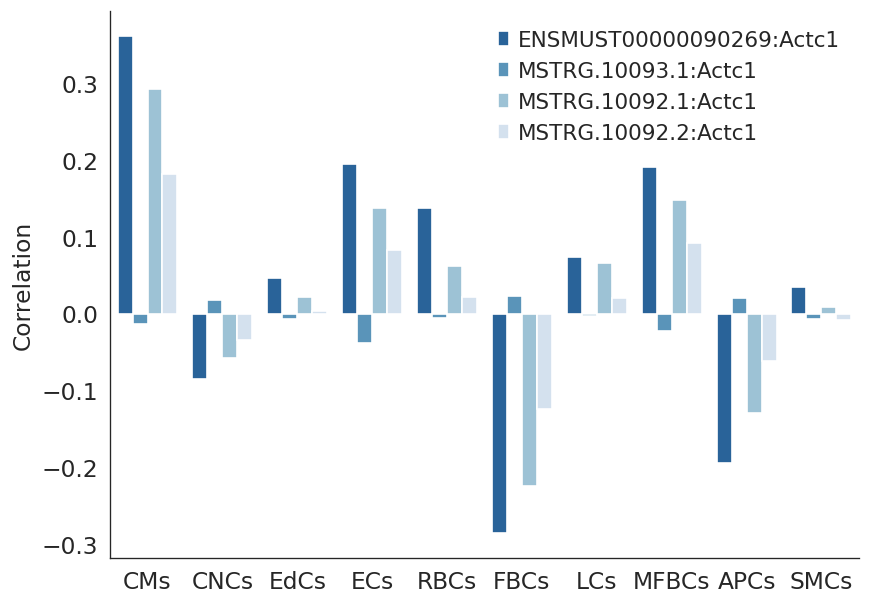

In [18]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, figsize=(8,6))
    g = sns.barplot(x="cell", y="value", hue="variable", data=data, palette="Blues_r", ax=ax)
    ax.set_ylabel('Correlation');
    ax.set_xlabel('');
    ax.legend(loc='upper right', frameon=False)
    sns.despine(ax=ax)
    
    for ext in ['pdf', 'svg']:
        filen = os.path.join(parent, 'ScNaST', 'paper', 'figures', '3', f'Actc1_cell_origin.{ext}')
        fig.savefig(filen, dpi=800, bbox_inches='tight')

Text(0, 0.5, 'Correlation')

Text(0.5, 0, '')

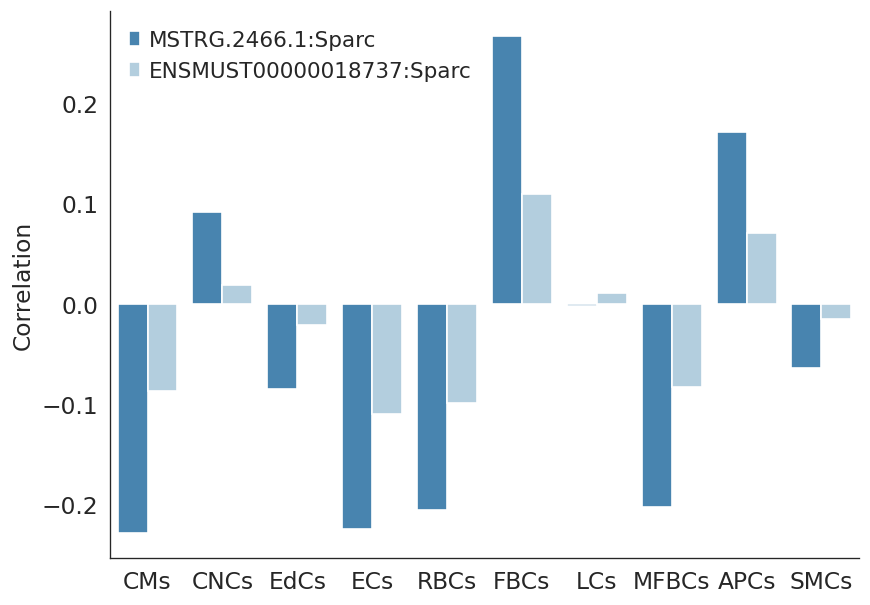

In [19]:
# Sparc

data = pd.DataFrame(list(zip(ColumnWiseCorrcoef(np.asarray(deconvolution), np.asarray(sparc.X.todense()[:,0].reshape((1, sparc.shape[0]))))[0], 
                    ColumnWiseCorrcoef(np.asarray(deconvolution), np.asarray(sparc.X.todense()[:,1].reshape((1, sparc.shape[0]))))[0],
                    list(adata.obsm['deconvolution']))),
                    columns =['MSTRG.2466.1:Sparc', 'ENSMUST00000018737:Sparc', 'cell'])
data = data.melt(id_vars=['cell'])
data.cell = data.cell.map(mapping_names)

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, figsize=(8,6))
    g = sns.barplot(x="cell", y="value", hue="variable", data=data, palette="Blues_r", ax=ax)
    ax.set_ylabel('Correlation');
    ax.set_xlabel('');
    ax.legend(loc='upper left', frameon=False)
    sns.despine(ax=ax)
    
    for ext in ['pdf', 'svg']:
        filen = os.path.join(parent, 'ScNaST', 'paper', 'figures', '3', f'Sparc_cell_origin.{ext}')
        fig.savefig(filen, dpi=800, bbox_inches='tight')

Isoform contribution to selected genes *.e.g* Actc1
---

In [28]:
catr = ['Infarct', 'Border zone', 'Remote zone 1', 'Remote zone 2']
# catr = ['Remote zone 2', 'Remote zone 1', 'Border zone', 'Infarct']
regions = []
for r in catr:
    actc1_reg = actc1[actc1.obs.anatomical_region==r, :].copy()
    regions.append(actc1_reg.X.sum(axis=0)[0]/actc1_reg.X.sum(axis=0)[0].sum()*100)
    
names = ['ENSMUST00000090269:Actc1', 'MSTRG.10093.1:Actc1', 'MSTRG.10092.1:Actc1', 'MSTRG.10092.2:Actc1']
data = [{k:v for k, v in zip(names, regions[i].tolist()[0])} for i in range(4)]
data = pd.DataFrame(data)
data['region'] = catr
melted = data.melt(id_vars=['region'])

Text(0, 0.5, '')

Text(0.5, 0, 'Isoform contribution (%)')

(3.5, -0.5)

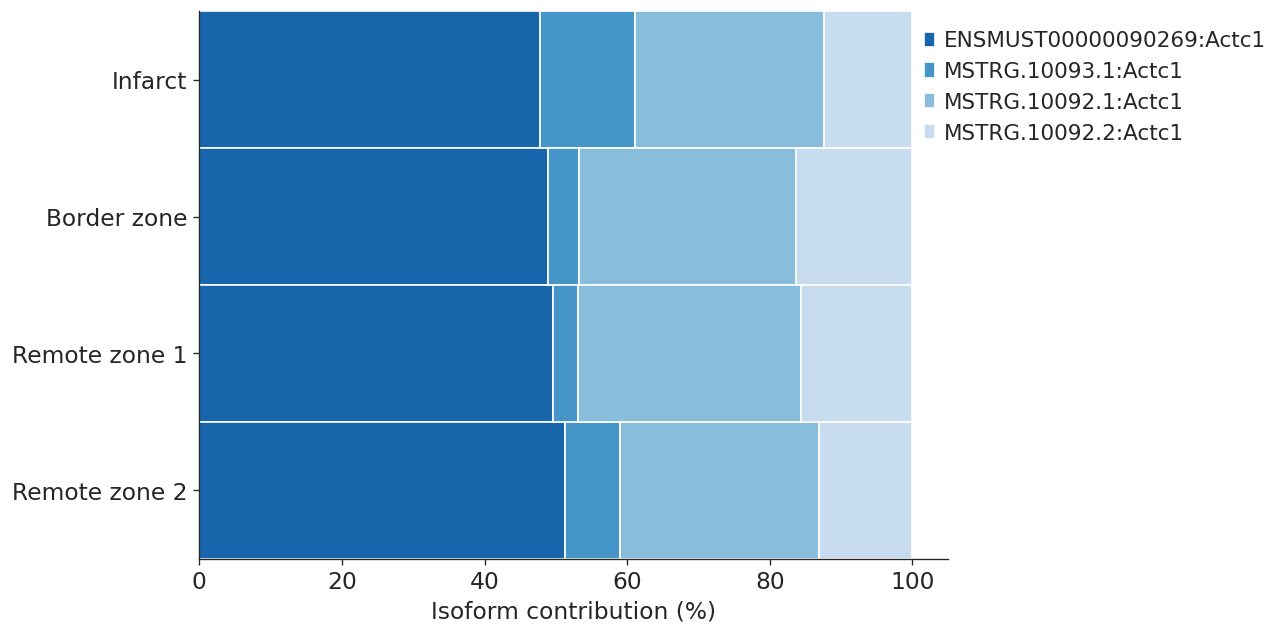

In [29]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(1, figsize=(8,6))
    g = data.plot(
    x = 'region',
    kind = 'barh',
    stacked = True,
    mark_right = True,
    colormap=new_cmap,
    width=1,
    ax=ax)
    ax.set_ylabel('');
    ax.set_xlabel('Isoform contribution (%)');
    ax.legend(loc='upper right', frameon=False, bbox_to_anchor=(1.45, 1))
    sns.despine(ax=ax)
    # Get the first two and last y-tick positions.
    miny, nexty, *_, maxy = ax.get_yticks()
    # Compute half the y-tick interval
    eps = (nexty - miny) / 2 
    ax.set_ylim(maxy+eps, miny-eps)
    
    for ext in ['pdf', 'svg']:
        filen = os.path.join(parent, 'ScNaST', 'paper', 'figures', '3', f'Actc1_trx_prop.{ext}')
        fig.savefig(filen, dpi=800, bbox_inches='tight')